In [22]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here
import pydicom
import glob
from itertools import chain
import matplotlib.image as mpimg

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [3]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
78900,00019369_001.png,Mass,1,19369,21,M,AP,2500,2048,0.168,0.168,NaN
95633,00025147_000.png,No Finding,0,25147,59,F,PA,2698,2353,0.143,0.143,NaN
24727,00006498_000.png,No Finding,0,6498,28,M,PA,2500,2048,0.171,0.171,NaN


In [4]:
## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
2844,00014116_006.png,Atelectasis|Infiltration,6,14116,054Y,M,AP,2500,2048,0.168000,0.168000
3398,00016778_003.png,Atelectasis|Infiltration|Pleural_Thickening,3,16778,025Y,M,AP,3056,2544,0.139000,0.139000
5461,00029729_000.png,No Finding,0,29729,035Y,M,PA,2021,2021,0.194311,0.194311


# Explore 2D Imaging Properties

We want to first look at patients who are diagnosed with *only* pneumonia.

In [12]:
all_xray_df['Finding Labels'].unique()

array(['Cardiomegaly', 'Cardiomegaly|Emphysema', 'Cardiomegaly|Effusion',
       'No Finding', 'Hernia', 'Hernia|Infiltration', 'Mass|Nodule',
       'Infiltration', 'Effusion|Infiltration', 'Nodule', 'Emphysema',
       'Effusion', 'Atelectasis', 'Effusion|Mass',
       'Emphysema|Pneumothorax', 'Pleural_Thickening',
       'Effusion|Emphysema|Infiltration|Pneumothorax',
       'Emphysema|Infiltration|Pleural_Thickening|Pneumothorax',
       'Effusion|Pneumonia|Pneumothorax', 'Pneumothorax',
       'Effusion|Infiltration|Pneumothorax', 'Infiltration|Mass',
       'Infiltration|Mass|Pneumothorax', 'Mass',
       'Cardiomegaly|Infiltration|Mass|Nodule',
       'Cardiomegaly|Effusion|Emphysema|Mass',
       'Atelectasis|Cardiomegaly|Emphysema|Mass|Pneumothorax',
       'Emphysema|Mass', 'Emphysema|Mass|Pneumothorax',
       'Atelectasis|Pneumothorax', 'Cardiomegaly|Emphysema|Pneumothorax',
       'Mass|Pleural_Thickening', 'Cardiomegaly|Mass|Pleural_Thickening',
       'Effusion|Infiltra

In [5]:
def show_images(pixel_array):
    mean_intensity = np.mean(pixel_array)
    std_intensity = np.std(pixel_array)
    new_img = pixel_array.copy()
    new_img = (new_img - mean_intensity)/std_intensity

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    axes[0].imshow(pixel_array)
    axes[1].hist(new_img.ravel(), bins = 256)
    fig.tight_layout()    

In [6]:
purely_pneumonia_cases_df = all_xray_df.loc[all_xray_df['Finding Labels'] == 'Pneumonia']
purely_pneumonia_cases_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
279,00000061_015.png,Pneumonia,15,61,77,M,AP,3056,2544,0.139,0.139,NaN
590,00000144_001.png,Pneumonia,1,144,83,M,AP,2500,2048,0.168,0.168,NaN
640,00000165_001.png,Pneumonia,1,165,76,M,PA,2992,2991,0.143,0.143,NaN
804,00000193_019.png,Pneumonia,19,193,55,M,AP,2500,2048,0.168,0.168,NaN
902,00000218_001.png,Pneumonia,1,218,33,M,PA,2048,2500,0.171,0.171,NaN


## No Finding case

Patient 1 has a diagnosis of No Finding.  Below we show the x-ray scan and a histogram of the normalized pixel intensities.

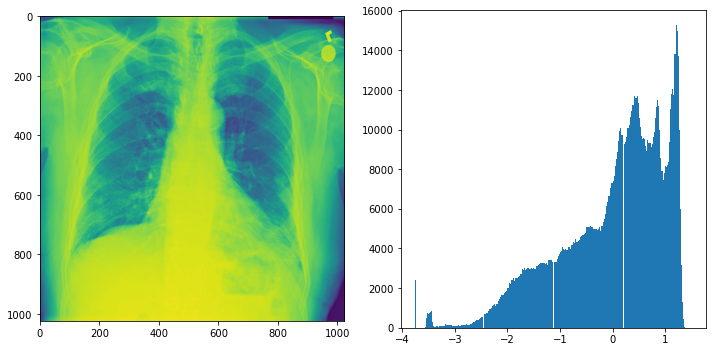

In [6]:
pixels1 = dcm1.pixel_array
show_images(pixels1)

Similarly, we look at x-ray scans and normalized pixel intensities for other patients.

## Pneumnoia-only cases

In [33]:
image_path = os.path.join('/data','images*', '*', '*.png')
globbed_paths = glob.glob(image_path)
all_image_paths = {os.path.basename(x): x for x in globbed_paths}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)

Scans found: 112120 , Total Headers 112120


In [32]:
pneumonia_only_df = all_xray_df.loc[all_xray_df['Finding Labels'] == 'Pneumonia']
pneumonia_only_df.head(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
279,00000061_015.png,Pneumonia,15,61,77,M,AP,3056,2544,0.139,0.139,NaN,/data/images_001/images/00000061_015.png
590,00000144_001.png,Pneumonia,1,144,83,M,AP,2500,2048,0.168,0.168,NaN,/data/images_001/images/00000144_001.png
640,00000165_001.png,Pneumonia,1,165,76,M,PA,2992,2991,0.143,0.143,NaN,/data/images_001/images/00000165_001.png


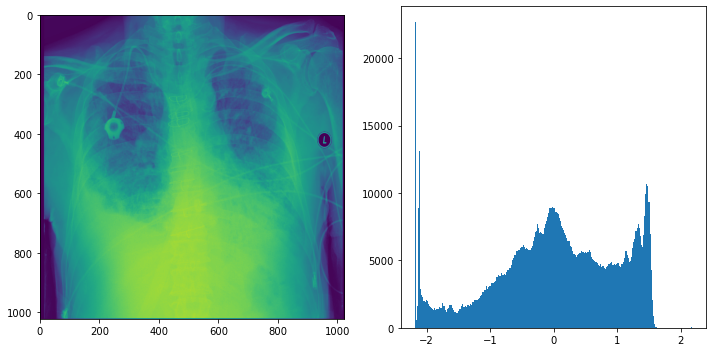

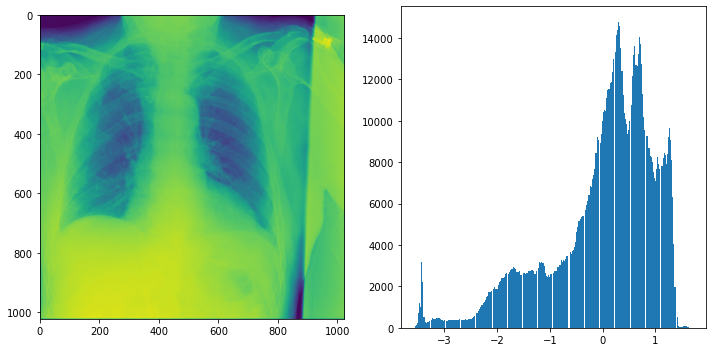

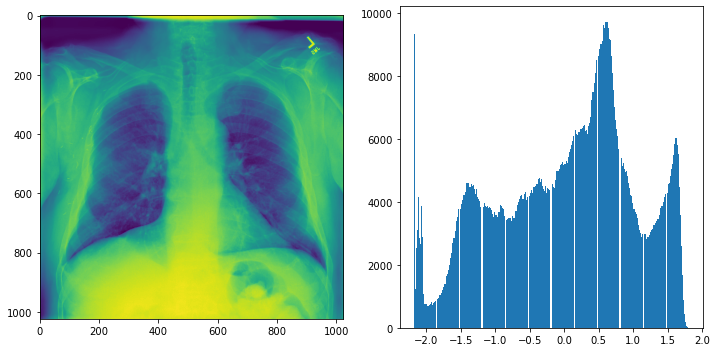

In [25]:
path_pneumonia_1 = pneumonia_only_df.loc[279, 'path']
img_1 = mpimg.imread(path_pneumonia_1)
show_images(img_1)

path_pneumonia_2 = pneumonia_only_df.loc[590, 'path']
img_2 = mpimg.imread(path_pneumonia_2)
show_images(img_2)

path_pneumonia_3 = pneumonia_only_df.loc[640, 'path']
img_3 = mpimg.imread(path_pneumonia_3)
show_images(img_3)

It's quite difficult to tell the pneumonia cases from the case with no finding.  Perhaps the histograms of the pneumonia cases extend further to the right.  This seems to be true of at least the first and third pneumonia cases. 

## Comorbidity cases

### Pneumonia with infiltration

In [31]:
pneumonia_infiltration_df = all_xray_df.loc[all_xray_df['Finding Labels'] == 'Infiltration|Pneumonia']
pneumonia_infiltration_df.head(1)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
901,00000218_000.png,Infiltration|Pneumonia,0,218,33,M,PA,2500,2048,0.171,0.171,NaN,/data/images_001/images/00000218_000.png


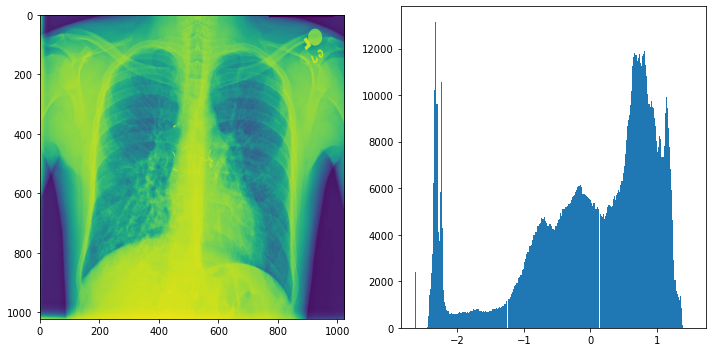

In [28]:
path_pneumonia_infiltration = pneumonia_infiltration_df.loc[901, 'path']
comorbid_img__1 = mpimg.imread(path_pneumonia_infiltration)
show_images(comorbid_img__1)

### Pneumonia with atelectasis

In [30]:
pneumonia_atelectasis_df = all_xray_df.loc[all_xray_df['Finding Labels'] == 'Atelectasis|Pneumonia']
pneumonia_atelectasis_df.head(1)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
2617,00000688_002.png,Atelectasis|Pneumonia,2,688,65,F,PA,2992,2991,0.143,0.143,NaN,/data/images_001/images/00000688_002.png


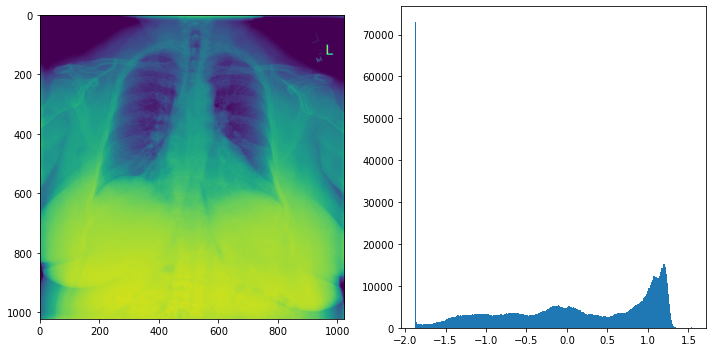

In [36]:
path_atelectasis_pneumonia = pneumonia_atelectasis_df.loc[2617, 'path']
comorbid_img__2 = mpimg.imread(path_atelectasis_pneumonia)
show_images(comorbid_img__2)

### Pneumonia with edema and infiltration

In [35]:
pneumonia_edema_infiltration_df = all_xray_df.loc[all_xray_df['Finding Labels'] == 'Edema|Infiltration|Pneumonia']
pneumonia_edema_infiltration_df.head(1)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
1716,00000459_041.png,Edema|Infiltration|Pneumonia,41,459,54,F,AP,3056,2544,0.139,0.139,NaN,/data/images_001/images/00000459_041.png


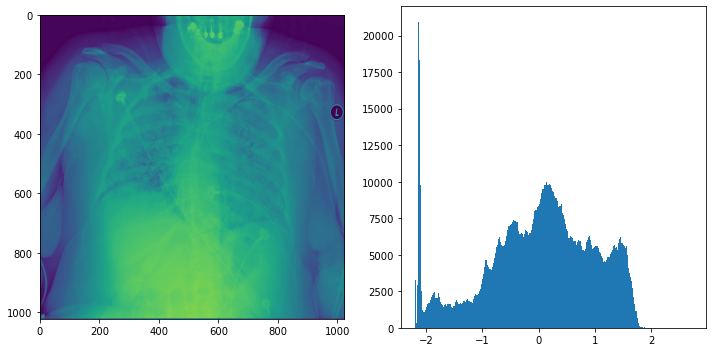

In [38]:
path_pneumonia_atelectasis_infiltration = pneumonia_edema_infiltration_df.loc[1716, 'path']
comorbid_img__3 = mpimg.imread(path_pneumonia_atelectasis_infiltration)
show_images(comorbid_img__3)

Comorbidities with pneumonia seem to muddy the waters more than anything else.  The histograms are more shifted
to the right than the normal case, but it is not easy to make a diagnosis from the image intensities (or the scans) alone.

Of course, the image intensities "flatten out" the actual scans.  And, of course, making diagnoses from the scans should be
highly non-trivial for a layman.

# Prepare DICOM Images for ML

### Let's look at the contents of the first DICOM:

In [16]:
dcm1 = pydicom.dcmread(mydicoms[0])

In [17]:
dcm1

(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.11129.5.5.110503645592756492463169821050252582267888
(0008, 0060) Modality                            CS: 'CT'
(0008, 1030) Study Description                   LO: 'No Finding'
(0010, 0020) Patient ID                          LO: '2'
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient's Age                       AS: '81'
(0018, 0015) Body Part Examined                  CS: 'CHEST'
(0018, 5100) Patient Position                    CS: 'PA'
(0020, 000d) Study Instance UID                  UI: 1.3.6.1.4.1.11129.5.5.112507010803284478207522016832191866964708
(0020, 000e) Series Instance UID                 UI: 1.3.6.1.4.1.11129.5.5.112630850362182468372440828755218293352329
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows       

Looking at the attributes listed above, I can see that I'm looking to extract the following attributes: 
* Modality
* Study Description
* Patient ID
* Patient's Sex
* Patient's Age
* Rows
* Columns

In [18]:
dcm1.Modality

'CT'

In [19]:
dcm1.StudyDescription

'No Finding'

In [20]:
dcm1.PatientID

'2'

In [21]:
dcm1.PatientSex

'M'

In [22]:
dcm1.PatientAge

'81'

In [23]:
dcm1.Rows

1024

In [24]:
dcm1.Columns

1024

## Now, let's create the dataframe that we want, and populate it in a loop with all of our DICOMS:

In [25]:
all_data = []

for i in mydicoms: 
    dcm = pydicom.dcmread(i)
    fields = [dcm.PatientID, int(dcm.PatientAge), dcm.PatientSex, dcm.Modality, dcm.StudyDescription,
             dcm.Rows, dcm.Columns]
    all_data.append(fields)

In [26]:
mydata = pd.DataFrame(all_data, 
                      columns = ['PatientID','PatientAge','PatientSex','Modality','Findings','Rows','Columns'])

In [27]:
mydata

,PatientID,PatientAge,PatientSex,Modality,Findings,Rows,Columns
0,2,81,M,CT,No Finding,1024,1024
1,2,81,M,DX,No Finding,1024,1024
2,2,81,M,DX,No Finding,1024,1024
3,1,58,M,DX,Cardiomegaly,1024,1024
4,61,77,M,DX,Effusion,1024,1024
5,2,81,M,DX,No Finding,1024,1024


# Exploring Population Metadata

In [28]:
d = pd.read_csv('sample_labels.csv')

In [29]:
## Here I'm just going to split up my "Finding Labels" column so that I have one column in my dataframe
# per disease, with a binary flag. This makes EDA a lot easier! 

all_labels = np.unique(list(chain(*d['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        d[c_label] = d['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
d.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
2342,00011898_000.png,No Finding,0,11898,051Y,F,PA,2362,2545,0.143000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3157,00015553_004.png,No Finding,4,15553,004Y,M,PA,1724,1553,0.143000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5454,00029678_001.png,Atelectasis|Nodule,1,29678,067Y,F,PA,2021,2021,0.194311,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [30]:
len(all_labels)

15

I see here that there are 15 unique types of labels found in my dataset

In [31]:
d[all_labels].sum()/len(d)

Atelectasis           0.090617
Cardiomegaly          0.025152
Consolidation         0.040314
Edema                 0.021049
Effusion              0.114877
Emphysema             0.022654
Fibrosis              0.014984
Hernia                0.002319
Infiltration          0.172494
Mass                  0.050660
No Finding            0.542990
Nodule                0.055833
Pleural_Thickening    0.031395
Pneumonia             0.011060
Pneumothorax          0.048341
dtype: float64

[Text(0, 0.5, 'Number of Images with Label')]

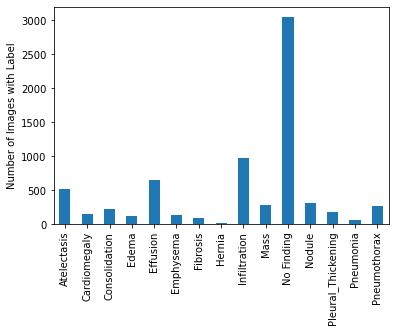

In [32]:
ax = d[all_labels].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')

Above, I see the relative frequencies of each disease in my dataset. It looks like 'No Finding' is the most common occurrence. 'No Finding' can never appear with any other label by definition, so we know that in 54.3% of this dataset, there is no finding in the image. Beyond that, it appears that 'Infiltration' is the most common disease-related label, and it is followed by 'Effusion' and 'Atelectasis.'

Since 'pneumonia' is what we're concerned with, I'm going to now look at how frequently it appears with all of the other diseases: 

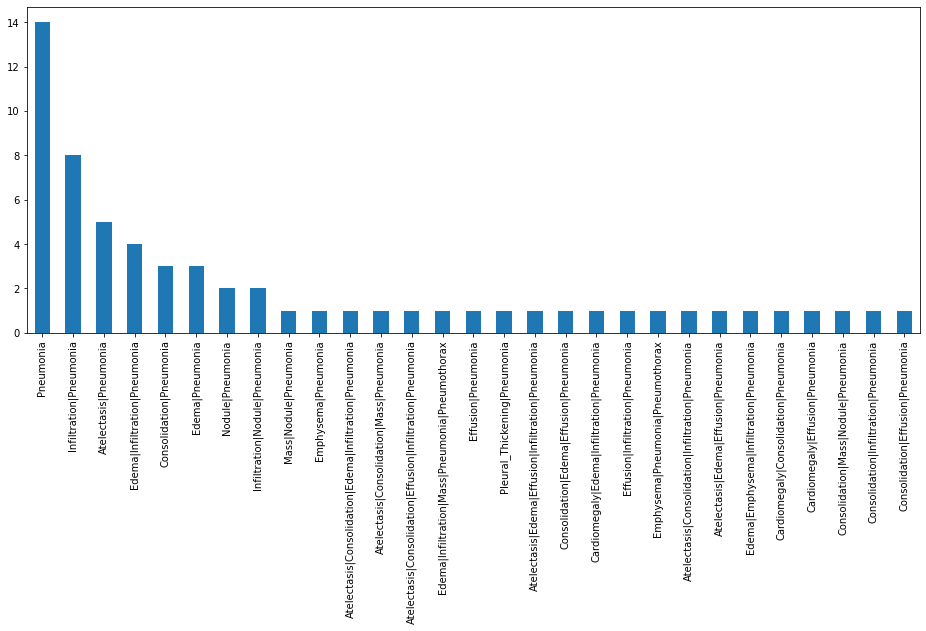

In [33]:
##Since there are many combinations of potential findings, I'm going to look at the 30 most common co-occurrences:
plt.figure(figsize=(16,6))
d[d.Pneumonia==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar')

It looks like pneumonia actually occurs alone for the most part, and that its most-common comorbidities are infiltration and atelectasis.

Now let's move on to looking at age & gender: 

In [34]:
pd.unique(d['Patient Age'])

array(['060Y', '057Y', '077Y', '079Y', '055Y', '068Y', '071Y', '063Y',
       '067Y', '056Y', '058Y', '075Y', '073Y', '054Y', '078Y', '047Y',
       '050Y', '045Y', '084Y', '030Y', '049Y', '061Y', '069Y', '051Y',
       '044Y', '087Y', '059Y', '031Y', '064Y', '053Y', '082Y', '072Y',
       '046Y', '080Y', '048Y', '021Y', '038Y', '062Y', '052Y', '023Y',
       '037Y', '022Y', '032Y', '070Y', '065Y', '040Y', '042Y', '041Y',
       '028Y', '035Y', '034Y', '066Y', '019Y', '039Y', '074Y', '026Y',
       '024Y', '085Y', '016Y', '029Y', '033Y', '013Y', '017Y', '020Y',
       '014Y', '043Y', '012Y', '009Y', '011Y', '027Y', '036Y', '081Y',
       '025Y', '018Y', '076Y', '083Y', '008Y', '006Y', '015Y', '002Y',
       '005Y', '010Y', '003Y', '089Y', '007Y', '086Y', '004Y', '094Y',
       '013M', '411Y', '001D', '088Y'], dtype=object)

In [35]:
def get_age_from_string(age_str):
    if age_str[-1] == 'D':
        return 0
    elif age_str[-1] == 'M':
        return 1
    else:
        stripped_age = age_str[:3].strip("0")
        if len(stripped_age) == 0:
            return 0
        else:
            return int(stripped_age)

In [36]:
d['AgeInYears'] = d['Patient Age'].map(lambda age_str: get_age_from_string(age_str))

Clearly no one can be 411 years old.

In [37]:
d = d[d['AgeInYears'] < 411]

(array([ 631.,  230.,  542.,  625.,  779., 1202.,  977.,  493.,  112.,
          14.]),
 array([ 0. ,  9.4, 18.8, 28.2, 37.6, 47. , 56.4, 65.8, 75.2, 84.6, 94. ]),
 <a list of 10 Patch objects>)

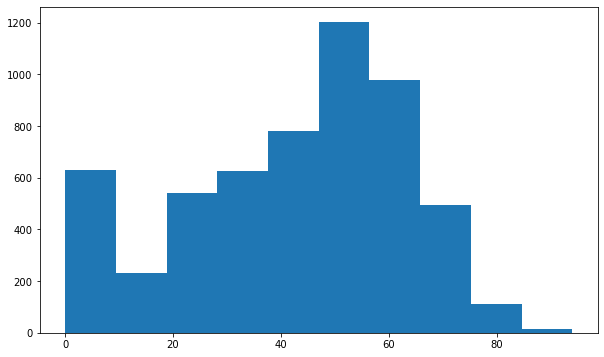

In [38]:
plt.figure(figsize=(10,6))
plt.hist(d['AgeInYears'])

(array([ 8.,  5.,  5.,  6.,  3.,  9.,  4., 12.,  5.,  5.]),
 array([ 2. ,  9.4, 16.8, 24.2, 31.6, 39. , 46.4, 53.8, 61.2, 68.6, 76. ]),
 <a list of 10 Patch objects>)

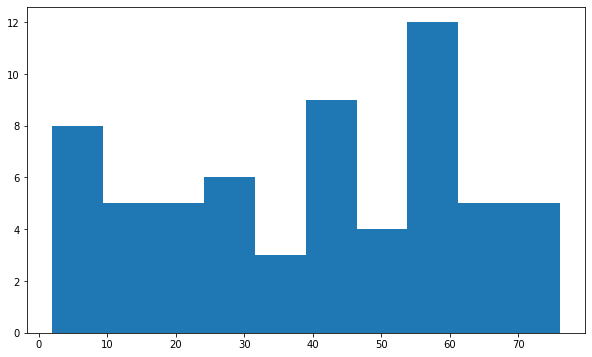

In [39]:
plt.figure(figsize=(10,6))
plt.hist(d[d.Pneumonia==1]['AgeInYears'])

Looks like the distribution of age across the whole population is quite different than it is specifically for pneumonia. Pneumonia occurs across all ages, although there is a peak at 60.

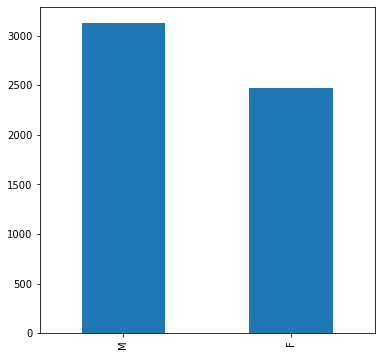

In [40]:
plt.figure(figsize=(6,6))
d['Patient Gender'].value_counts().plot(kind='bar')

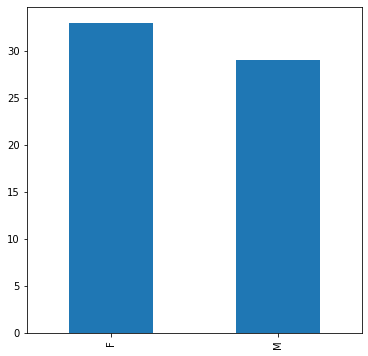

In [41]:
plt.figure(figsize=(6,6))
d[d.Pneumonia ==1]['Patient Gender'].value_counts().plot(kind='bar')

There are more males than females in the general population, but more females have pneumonia.